# CSCE 823 Homework 2 Example Solution

Original Author:  Mr. Mark Carroll (CSCE 823, 2019)


In [1]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import callbacks
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

print (pd.__version__)

######### DEFINITION OF GLOBAL VARIABLES #########
RUN_CONFIGURATION_LOOP = False

C:\Users\brett\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\brett\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\brett\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\brett\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

1.0.1


C:\Users\brett\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Tell keras to use all of the GPU
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

## 1. Obtain and load the two datasets for regression

Import datasets

In [3]:
non_test_data = pd.read_csv('CSCE823_HW2_regression_non_testdata.csv')
test_data = pd.read_csv('CSCE823_HW2_regression_testdata.csv')

## 2. Data Exploration
Explore the data!

#### a. Build a function to return the value of z from the value of the mathematical saddle function

In [4]:
# Compute the output of the saddle function
def computeSaddleFunction(x1, x2):
    return (np.power(x1, 2) - np.power(x2, 2))

# Compute the saddle function (z = x1^2 - x2^2) for the non-test data
#non_test_data_np = non_test_data.to_numpy()
non_test_data_np = np.asarray(non_test_data)
saddle_non_test = computeSaddleFunction(non_test_data_np[:, 0], non_test_data_np[:, 1])

#### b. Build a function to display a 3d representation of the saddle

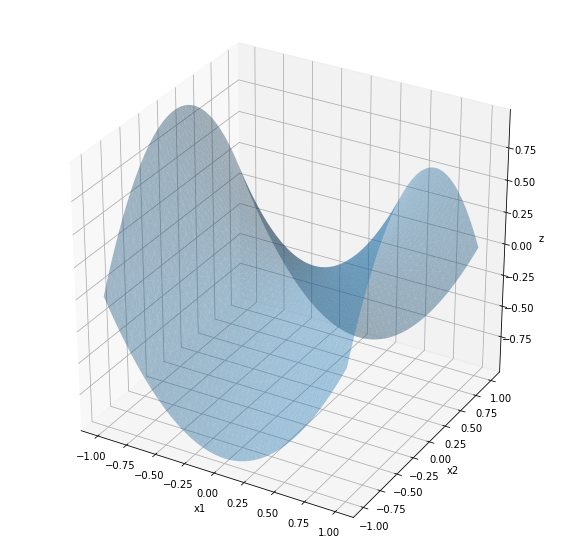

In [5]:
# Create a 3D plot of the input data (x1, x2) and the output of the saddle function (z)
def plot3DSaddleSurface(x1, x2, z):
    # Create matplotlib figure and axes objects with 3D projection
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the data surface and make labels
    ax.plot_trisurf(x1, x2, z, alpha=0.4)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('z')
        
    # Return the axes object for adding additional info to the same plot
    return ax
    
# Code below is just to test to make sure the plot3DSurface function works.  Should create a perfect surface plot
# Note that I realize the code below is a bit messy, just using this for a quick debug of the plot function.
ref_x1 = np.linspace(-1.0, 1.0, 50)
ref_x2 = np.linspace(-1.0, 1.0, 50)
ref_x1, ref_x2 = np.meshgrid(ref_x1, ref_x2)
ref_x1 = np.ravel(ref_x1)
ref_x2 = np.ravel(ref_x2)
ref_z = computeSaddleFunction(ref_x1, ref_x2)
ref_z = np.ravel(ref_z)

# Uncomment to see reference saddle surface
plot3DSaddleSurface(ref_x1, ref_x2, ref_z)

#### c. Visually explore the non-test data using both 2d representations and 3d representations
The 2d histogram shows the distribution of x1 and x2 values for the non-test dataset. The distribution is not uniform, I wonder how this will impact the training? Some areas which lack data would become problem areas possibly.

Text(0.5, 0.92, 'Reference saddle surface and data points')

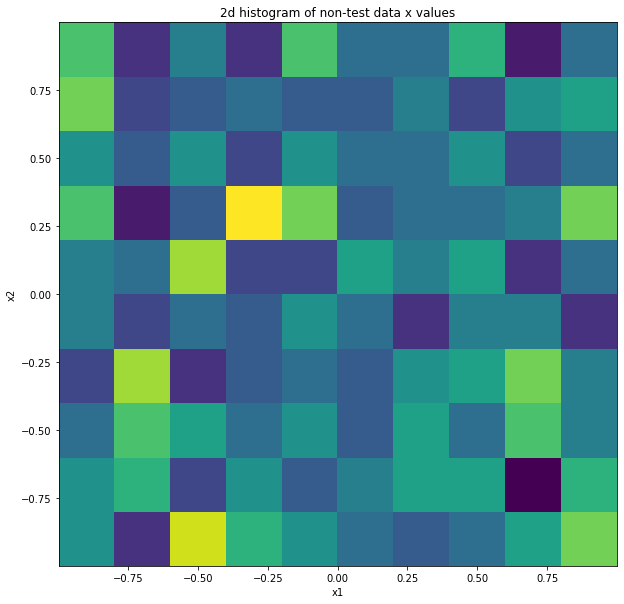

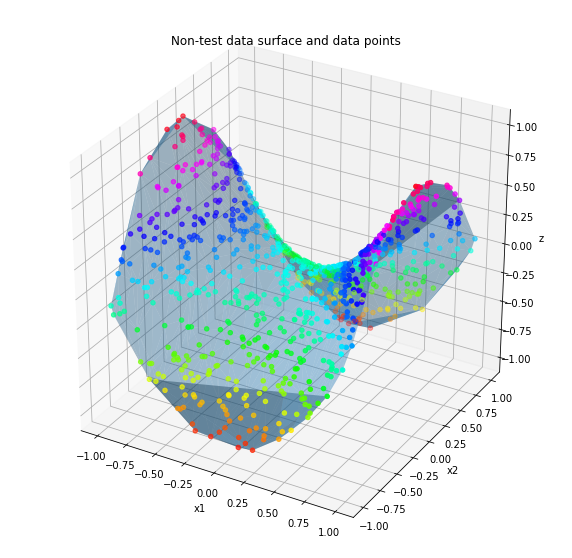

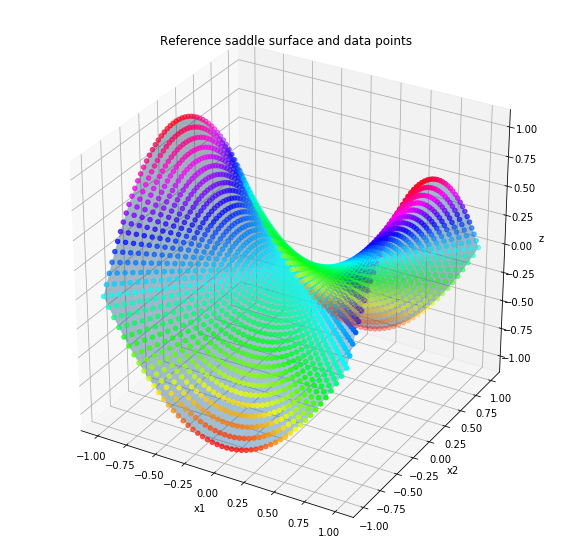

In [6]:
# Visually explore the non-test data

# Plot a 2D histogram of the non-test dataset
plt.figure(figsize=(10,10))
plt.hist2d(non_test_data['x1'], non_test_data['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('2d histogram of non-test data x values')

# Plot the 3D saddle surface with the points as a 3D scatterplot on top of the non-test dataset
axes_object = plot3DSaddleSurface(non_test_data_np[:, 0], non_test_data_np[:, 1], saddle_non_test)
axes_object.scatter3D(non_test_data_np[:, 0], non_test_data_np[:, 1], saddle_non_test, 
                      c=saddle_non_test, cmap='hsv')
plt.title('Non-test data surface and data points')


# Plot the 3D saddle surface with the points as a 3D scatterplot on top of the perfect reference dataset
axes_object = plot3DSaddleSurface(ref_x1, ref_x2, ref_z)
axes_object.scatter3D(ref_x1, ref_x2, ref_z, c=ref_z, cmap='hsv')
plt.title('Reference saddle surface and data points')


#### d. Determine the raw errors from the non-test set, display those errors using a histogram, and discuss the histogram shape
The histogram shape appears to be gaussian with a mean centered around 0 and most points falling between +- 0.4. There doesn't appear to be any noticable skew in the plot but there does appear to be quite a bit of noise (I would expect a histogram with 0 noise to be a smooth histogram, this one is choppy which indicates noise). The noise will negatively impact the ability of the model to generalize.  However, for this specific example the noise doesn't appear to be extreme.  We'll see how much it negatively impacts model performance, my guess is it will negatively impact it but not a large amount. 

Text(0.5, 1.0, 'Histogram of the error between observed Z and calculated Z')

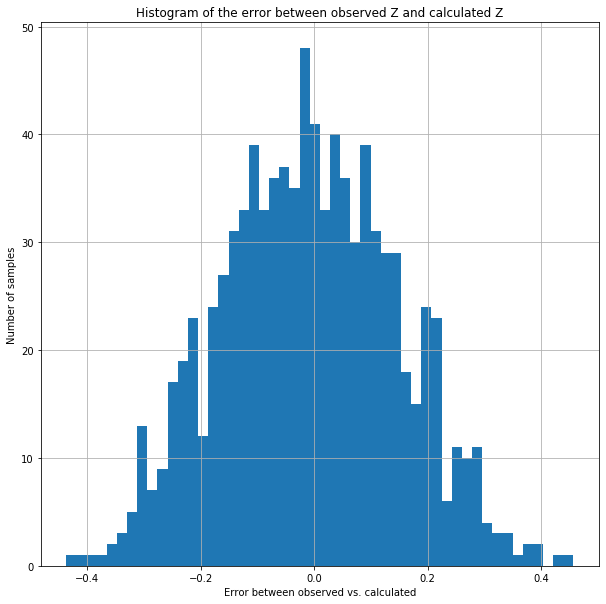

In [7]:
# Determine errors from output of saddle function vs. those values from the original non-test dataset
raw_error = saddle_non_test - non_test_data['y']

plt.figure(figsize=(10,10))
plt.grid()
plt.hist(raw_error, bins=50)
plt.xlabel('Error between observed vs. calculated')
plt.ylabel('Number of samples')
plt.title('Histogram of the error between observed Z and calculated Z')

#### e. Scatterplot of the true saddle values vs. raw errors
The following scatterplot shows the errors on the non-test data against the true saddle values (returned from the saddle function). It appears the majority of the errors occur when the true saddle value is about +- 0.5. Also, the errors are "small", only +- 0.4 as also shown in the histogram above. There is visibally a higher concentration of points around the true saddle value of 0.

Text(0.5, 1.0, 'Non-test set errors')

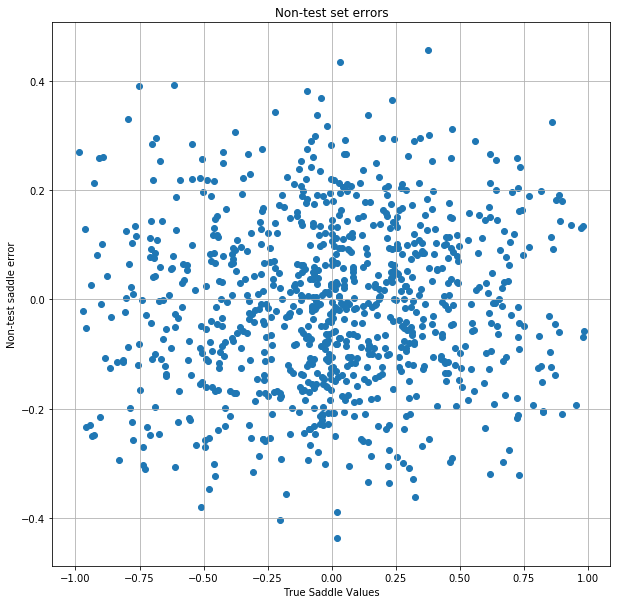

In [8]:
# Plot the true saddle values vs. raw errors
plt.figure(figsize=(10,10))
plt.grid()
plt.scatter(saddle_non_test, raw_error)
plt.xlabel('True Saddle Values')
plt.ylabel('Non-test saddle error')
plt.title('Non-test set errors')

#### f. Determine and report the MSE, RMSE, and MAE on the raw errors
Below are the 3 metrics to beat. I have no reference yet for if this will be difficult but a MSE of 0.023 seems very small.

In [9]:
# Compute the MSE, RMSE, and MAE for the actual values vs. input values from the file
mse = np.mean((non_test_data['y'] - saddle_non_test)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(non_test_data['y'] - saddle_non_test))
print('MSE is ', mse)
print('RMSE is ', rmse)
print('MAE is ', mae)

MSE is  0.02363522500631578
RMSE is  0.15373751983922396
MAE is  0.12465195801133516


## 3. Prepare the data for training/validation

In [10]:
# Split the DF up into input data (x_data) and output data (y_data)
x_data = non_test_data.drop(['y'], axis=1)
y_data = non_test_data['y']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, train_size=0.8, random_state=1)


In [11]:
# Define a loss function to use during model fitting.  There are many built in functions to do this but I 
# wanted to implement my own to see how it was done.
def mse_loss(y_true, y_pred):
    return (K.mean(K.square(y_pred - y_true)))

# Define score function for GridSearchCV
def mse_scorer(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

## 4. Build a function which accepts hyper-parameter configurations and returns a (compiled, but untrained) Keras model

In [12]:
def buildKerasModel(optimizer='adam', num_hidden_layers=1, hidden_layer_width=2, activation_function='relu', 
                    learning_rate=0.001):
    
    # Create the model for solving XOR
    model = Sequential()

    # Start with the input layer.  This should always take in 2 inputs (x1 and x2) for this specific problem.
    model.add(Dense(2, activation='sigmoid', input_dim=2))

    # Create and add each hidden layer.
    # With the way GridSearch works there's no easy way to set the number of nodes and activation function
    # to be different per layer. Will look into this later.
    for ii in range(num_hidden_layers):
        model.add(Dense(hidden_layer_width, activation=activation_function))

    # Create and add the output layer.
    model.add(Dense(1, activation='linear'))

    # Complile the model and return
    model.compile(optimizer=optimizer, loss=mse_loss, metrics=['mse'])
    
    # Set the learning rate to the one passed into this function
    keras.backend.set_value(model.optimizer.lr, learning_rate)
    
    return model

## 5. Define configurations for multi-layer ANNs and include rationale for your decisions
I chose to try 3 and 6 hidden layers, number of nodes per hidden layer to be 3 and 6, activation functions to be relu and sigmoid, and a learning rate of 0.05 and 0.0005. I chose the values for the hidden layers because this function isn't a difficult function to fit a surface to, 3 hidden layers and 3 nodes per layer might be enough but in case it isn't I chose 6 nodes and 6 hidden layers as a backup. Also, the activation functions were chosen because the activation functions for the hidden layers have to be non-linear to learn a non-linear surface.  However, I did read relu was strongly recommended for hidden layers over sigmoid due to numerical issues around 0 so we'll see if sigmoid performs well. The learning rates were chosen based on experience with the previous homework, values too large wouldn't work at all (>0.1) but values too small learned too slowly. Learning rates of 0.05 and 0.005 seemed like happy mediums.  I also decided to use a reduce LR on plateau callback . The optimizer SGD was chosen over the others like ADAM for the momentum feature, which I found to be useful when playing around with the non-test dataset. 

In [13]:
# Define a bunch of parameters to try for gridsearch
num_hidden_layers = [3, 6]
hidden_layer_width = [3, 6]
activation_functions = ['sigmoid', 'relu']
optimizers = ['sgd']
learning_rates = [0.05, 0.005]

# Create callback for reducing LR based on encountered plateau regions
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.99, patience=2, min_lr=0.00001, cooldown=1)

# Set batch size and epochs. These values were experimentally determined
batch_size = 16
epochs = 500

## 6. Using the training set, train the model on each of the configurations you developed in the previous step
None that for the current configuration it takes ~150 seconds per parameter sweep.  This is running on a RTX 2070 GPU.  I have no idea how other people in the class got their runtimes down to a few seconds per paramater group unless their batch_size was the same as the number of epochs, but I noticed poor performance when increasing batch_size too much.

#### a. Note, this block takes ~35-40 minutes to run. Run at your own peril.

In [14]:
# Only run this training step if the global variable is true
# Note that for the curr
if RUN_CONFIGURATION_LOOP:
    
    regressor = KerasRegressor(build_fn=buildKerasModel, batch_size=batch_size, epochs=epochs, verbose=0)
    hyperparams = {'optimizer' : optimizers, 'num_hidden_layers' : num_hidden_layers,
                  'hidden_layer_width' : hidden_layer_width, 'learning_rate' : learning_rates,
                  'activation_function' : activation_functions}
    
    # Create score function for the grid search
    grid_regression_scorer = make_scorer(mse_scorer, greater_is_better=False)
    
    # Hacky solution to force number of cross-val folds to be 1 (cv=...)
    grid = GridSearchCV(estimator=regressor, param_grid=hyperparams, n_jobs=1,
                       cv=ShuffleSplit(test_size=0.20, n_splits=1, random_state=0),
                       scoring=grid_regression_scorer)
    
    grid_result = grid.fit(x_data, y_data, callbacks=[reduce_lr])


#### b. Report the best configuration and discuss
The best configuration set can be found in step 7 (best_params). Based on reading I did i'm not surprised relu was the best activation function (see comments in markdown box above about parameter selection). I'm surprised that 6 hidden layers and 6 hidden nodes per layer was beaten by 3 hidden layers and 6 nodes. I would have thought the more layers/nodes the more likely the model would be to overfit and get a smaller MSE value (which is obviously not wanted). During my exploration I also found a learning rate too small didn't result in a low MSE within any reasonable number of epochs, so I'm not entirely surprised a LR of 0.05 was best.

In [15]:
#print('Grid Search Best score', grid_result.best_score_)
#print('Grid Search Best Parameters', grid_result.best_params_)
#print(grid_result.cv_results_)

## 7. Select the best configuration and hard code it

In [16]:
# Hard code the best parameters
best_params = {'optimizer' : 'sgd', 'num_hidden_layers' : 3, 'hidden_layer_width' : 6,
              'learning_rate' : 0.05, 'activation_function' : 'relu'}

# Generate and compile the model
best_model = buildKerasModel(**best_params)


## 8. Retrain your model using all the non-test data
NOTE: Everytime a new model is trained the results below can change. I've noticed histograms change from 0 mean to non-zero mean and skewness. Any text below is based on the models I trained after running my entire notebook so the text may not reflect the plots anymore if it's re-run.

In [17]:
# Retrain the model on the non-test data
history = best_model.fit(x=x_data, y=y_data, batch_size=batch_size, epochs=epochs, verbose=0,
                         callbacks=[reduce_lr])

Text(0, 0.5, 'Loss (MSE)')

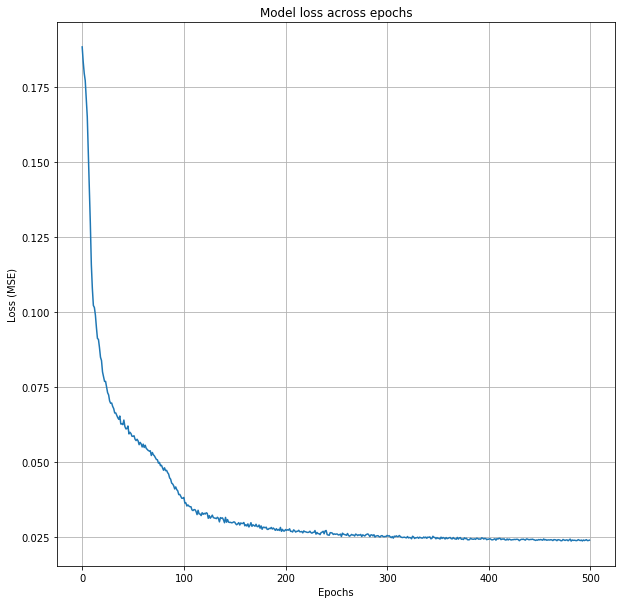

In [18]:
# Make a quick epoch vs. loss plot
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(history.history['loss'])
plt.title('Model loss across epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

## 9. Determine if your model trained on all the non-test data produces saddle-function predictions better than the non-test data y-values themselves

#### a. Run predictions on all the non-test data

In [19]:
# Make regression predictions on the non-test data
y_predict = best_model.predict(x_data)

#### b. Determine the prediction errors on the non-test set
This is a really interesting plot. So the red histogram is the raw error from the original non-test dataset and the blue is the error from the prediction I just ran. As you can see both histograms have 0 mean but the blue has much less variance than the red histogram.  This means the trained model was able to better generalize to the true curve surface and average out some of the noise from the non-test dataset. So all in all, the prediction error is less than the raw error which means the model trained fairly successfully with the given parameters.

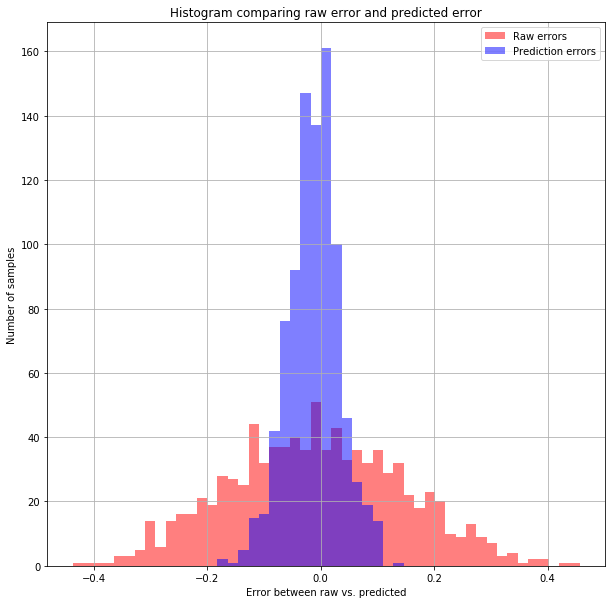

In [20]:
# Compute the prediction errors from the "true" values I computed with the saddle function
predict_error = saddle_non_test - y_predict.flatten()

# Plot the histogram of the prediction errors

#compute the bins first on the full range of errors
all_err = np.concatenate((raw_error, predict_error))
bins = np.linspace(np.min(all_err),np.max(all_err),50)

plt.figure(figsize=(10,10))
plt.grid()
plt.hist(raw_error, bins, color='r',alpha = 0.5)
plt.hist(predict_error, bins, color='b',alpha = 0.5)
plt.xlabel('Error between raw vs. predicted')
plt.ylabel('Number of samples')
plt.title('Histogram comparing raw error and predicted error')
plt.legend(['Raw errors', 'Prediction errors'])
#plt.xlim([-0.5, 0.5])

#### c. Provide a scatterplot of the true saddle values versus prediction errors
If the model was perfect this scatterplot would show a straight line going from the bottom left to the upper right. However, this scatterplot shows the predicted error was fairly small between +- 0.25 and was largest near the extremes where true and predicted were both +- 1. I believe this is where the surface has the largest slope (or rather the derivative has the largest slope).

(-1, 1)

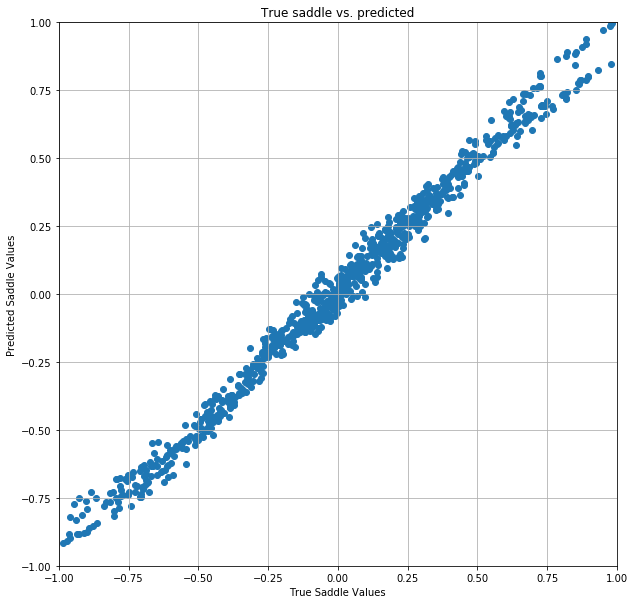

In [21]:
# Plot the saddle points vs. the predicted errors
plt.figure(figsize=(10,10))
plt.grid()
plt.scatter(saddle_non_test, y_predict)
plt.xlabel('True Saddle Values')
plt.ylabel('Predicted Saddle Values')
plt.title('True saddle vs. predicted')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

#### d. Determine and report the MSE, RMSE, and MAE on the non-test set prediction errors
My model did beat the raw error statistics. This means my model was able to generalize and average out the noise from the original dataset.

In [22]:
# Compute the MSE, RMSE, and MAE for the non-test set prediction error
mse = np.mean((predict_error)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predict_error))
print('MSE is ', mse)
print('RMSE is ', rmse)
print('MAE is ', mae)

MSE is  0.002222157406668054
RMSE is  0.047139764601322034
MAE is  0.03656269528196499


## 10. Evaluate the model fit on the test data
NOTE: Everytime a new model is trained the results below can change. I've noticed histograms change from 0 mean to non-zero mean and skewness. Any text below is based on the models I trained after running my entire notebook so the text may not reflect the plots anymore if it's re-run.

In [23]:
# Make regression predictions on the non-test data
y_predict_test = best_model.predict(test_data.drop(['y'], axis=1))

# Compute the prediction errors from the "true" values I computed with the saddle function
#test_data_np = test_data.to_numpy()
test_data_np = np.asarray(test_data)
saddle_test = computeSaddleFunction(test_data_np[:, 0], test_data_np[:, 1])
test_predict_error = saddle_test - y_predict_test.flatten()

#### a. Build a 3d scatterplot of the test dataset predicted values overlayed on the 3d surface of the saddle function. Discuss where your model performed well and where it struggled
I realize the plot is difficult to see because it can't be rotated, but red dots represent errors <= 0.1 and blue dots are errors > 0.1. From the plot it can be seen that the largest errors occur at or near the edges of the surface. Maybe making the network larger could improve the performance? Something to investigate.

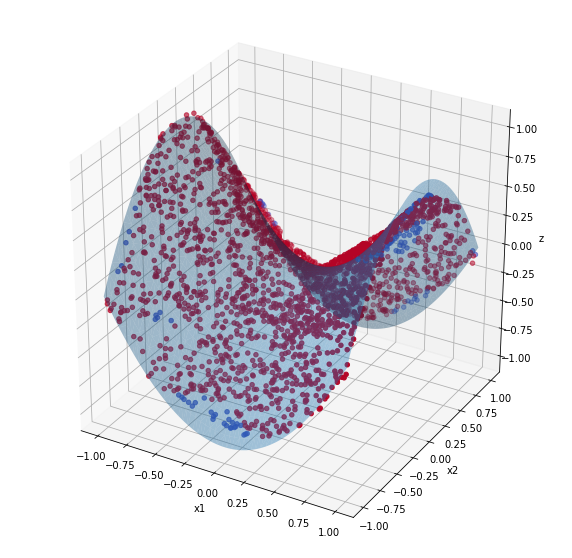

In [24]:
# Construct 3D scatter plot on top of the reference saddle function
axes_object = plot3DSaddleSurface(ref_x1, ref_x2, ref_z)
color_array = np.abs(test_predict_error) <= 0.1
axes_object.scatter3D(test_data['x1'], test_data['x2'], y_predict_test, c=color_array, cmap='coolwarm')

#### b. Determine, display, and discuss the histogram of prediction errors from the predictions in the test set
The histogram shape is gaussian. The mean is near -0.05 and the standard deviation is quite small. The shape to be skewed left with a tail on the right. I would say in general the majority of the prediction error was +- 0.1 with 
few outliers (which can be seen on the scatterplot above as well).

Text(0.5, 1.0, 'Histogram of the prediction errors')

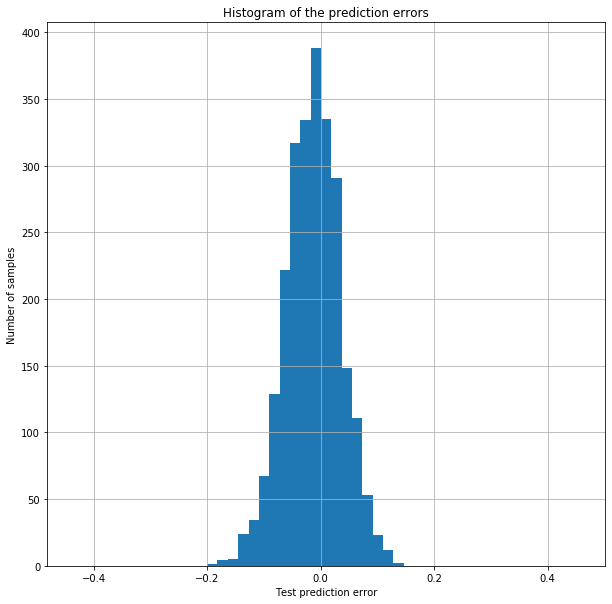

In [25]:
# Plot the histogram of the prediction errors
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(test_predict_error, bins)
plt.xlabel('Test prediction error')
plt.ylabel('Number of samples')
plt.title('Histogram of the prediction errors')
#plt.xlim([-0.6, 0.6])

#### c. Display and discuss residuals
If the model was perfect I would expect to see a horizontal line at 0. However, the results from my model are decent. You can see some general shape or wavy-ness to the residual plot. This could indicate a bias on certain parts of the surface. I'm going to need to think about this shape for a bit longer. In general the largest errors occur near +- 1 which is that I observed in the scatterplot above and the performance seems decent.

(-1, 1)

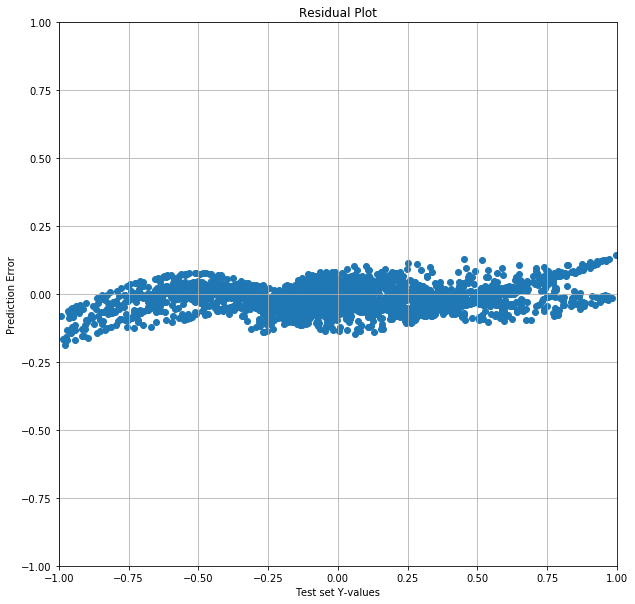

In [26]:
# 2D scatterplot of the test set residuals
plt.figure(figsize=(10,10))
plt.grid()
plt.scatter(test_data['y'], test_predict_error)
plt.xlabel('Test set Y-values')
plt.ylabel('Prediction Error')
plt.title('Residual Plot')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

#### d. Determine and report the error measures on the test set predictions
Similiar to the non-test performance, my model did beat the raw error statistics. This means my model was able to generalize and average out the noise from the original dataset. Given more time I would investigate the batch_size and epochs more. I think batch_size could have a significant impact on noise averaging based on some information I read. Also, my network seemed to favor node count in the hidden layers over more layers. I'd also investigate maybe more nodes for the 3 hidden layers I chose or maybe less hidden layers but more nodes.

In [27]:
# Compute the MSE, RMSE, and MAE for the test set prediction error
mse = np.mean((test_predict_error)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_predict_error))
print('MSE is ', mse)
print('RMSE is ', rmse)
print('MAE is ', mae)

MSE is  0.0025040492758334693
RMSE is  0.05004047637496539
MAE is  0.0396249876410345
